In [1]:
import pandas as pd

In [2]:
data_dir = ['./data/trial3/', './data/trial4/']

In [3]:
df = pd.DataFrame()
for location in data_dir:
    df_ = pd.read_csv(location+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])
    # Rename data location
    df_.iloc[:,0:3] = df_.iloc[:,0:3].apply(lambda x: location + 'IMG/' + x.str.split('\\').str[-1])
    # Append to the training dataframe
    df = pd.concat([df,df_])

In [4]:
# df = pd.read_csv(data_dir+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])

In [5]:
df.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,./data/trial3/IMG/center_2021_01_06_19_41_25_4...,./data/trial3/IMG/left_2021_01_06_19_41_25_443...,./data/trial3/IMG/right_2021_01_06_19_41_25_44...,0.0,0.0,0.0,0.000082
1,./data/trial3/IMG/center_2021_01_06_19_41_25_5...,./data/trial3/IMG/left_2021_01_06_19_41_25_546...,./data/trial3/IMG/right_2021_01_06_19_41_25_54...,0.0,0.0,0.0,0.000078
2,./data/trial3/IMG/center_2021_01_06_19_41_25_6...,./data/trial3/IMG/left_2021_01_06_19_41_25_649...,./data/trial3/IMG/right_2021_01_06_19_41_25_64...,0.0,0.0,0.0,0.000082
3,./data/trial3/IMG/center_2021_01_06_19_41_25_7...,./data/trial3/IMG/left_2021_01_06_19_41_25_752...,./data/trial3/IMG/right_2021_01_06_19_41_25_75...,0.0,0.0,0.0,0.000078
4,./data/trial3/IMG/center_2021_01_06_19_41_25_8...,./data/trial3/IMG/left_2021_01_06_19_41_25_857...,./data/trial3/IMG/right_2021_01_06_19_41_25_85...,0.0,0.0,0.0,0.000079


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 0 to 3878
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   center_cam  7867 non-null   object 
 1   left_cam    7867 non-null   object 
 2   right_cam   7867 non-null   object 
 3   steering    7867 non-null   float64
 4   throttle    7867 non-null   float64
 5   brake       7867 non-null   float64
 6   speed       7867 non-null   float64
dtypes: float64(4), object(3)
memory usage: 491.7+ KB


In [7]:
df_clean = df.copy()

In [8]:
# df_clean.iloc[:,0:3] = df_clean.iloc[:,0:3].apply(lambda x: data_dir + 'IMG/' + x.str.split('\\').str[-1])

In [9]:
# df_clean.head()

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
images = []
measurements = []

In [12]:
df_clean['center_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x));

In [13]:
steering_offset = 0.02
# Left Camera Modifications
df_clean['left_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x + steering_offset));
# Right Camera Modifications
df_clean['right_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x - steering_offset));

In [14]:
import numpy as np

In [15]:
X_train = np.array(images)
y_train = np.array(measurements)

# Training

In [16]:
import tensorflow as tf

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D, MaxPool2D, Dropout, Cropping2D  

In [18]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [19]:
X_train.shape

(23601, 160, 320, 3)

In [20]:
# model = Sequential()
# model.add(Flatten(input_shape=(160,320,3)))
# model.add(Dense(1))

In [21]:
import cv2

In [22]:
modified_images = []

In [23]:
scale_percent = 80 # percent of original size
width = int(X_train[0].shape[1] * scale_percent / 100)
height = int(X_train[0].shape[0] * scale_percent / 100)
dim = (width, height)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for image in X_train:
    normalized = image.copy()
    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])
    grayscale = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    downscaled = cv2.resize(grayscale, dim, interpolation=cv2.INTER_AREA)
    modified_images.append(downscaled)
    # # Also flip the image
    # modified_images.append(cv2.flip(downscaled, 1))
# plt.imshow(cv2.resize(X_train[0], dim, interpolation=cv2.INTER_AREA))

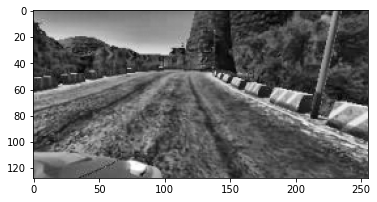

In [24]:
plt.imshow(modified_images[-1], cmap='gray')

In [25]:
# plt.imshow(cv2.flip(modified_images[-1],1), cmap='gray')

In [26]:
X_train_modified = np.array(modified_images)
# Adding a dimension for Keras processing purposes
X_train_modified = np.expand_dims(X_train_modified, 3)
# y_train_modified = np.concatenate([measurements, np.multiply(measurements, -1.0)])

In [27]:
tf.keras.backend.clear_session()

In [28]:
model = Sequential()
# Input Layer
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(height, width, 1)))
model.add(Cropping2D(cropping=((40,10),(0,0))))
# model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(160,320,1)))
# Convolution 1
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 2
model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 3
model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
# model.add(MaxPool2D(strides=(1,1)))
# Convolution 4
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 5
model.add(Conv2D(64, (3,3), activation='relu'))
# Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.25))
# Fully Connected 1
model.add(Dense(400, activation='relu'))
# Fully Connected 2
model.add(Dense(100, activation='relu'))
# Fully Connected 3 with Dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(1));

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 256, 1)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 78, 256, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 37, 126, 24)       624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 125, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 61, 36)        21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 60, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 28, 48)         4

In [30]:
# model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train_modified, y_train, epochs=1, batch_size=256, validation_split=0.2, shuffle=True)

In [31]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs\\fit\\"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)

In [33]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_modified, y_train, epochs=30, batch_size=256, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])

Train on 18880 samples, validate on 4721 samples
Epoch 1/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0156 - acc: 0.1499 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 2/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0096 - acc: 0.1499 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 3/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0086 - acc: 0.1499 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 4/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0082 - acc: 0.1499 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 5/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0075 - acc: 0.1499 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 6/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0074 - acc: 0.1499 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 7/30
18880/18880 [==============================] - 22s 1ms/sample - loss: 0.0074 - acc

In [34]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train_modified, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])

In [35]:
model.save('model.h5')

In [36]:
# from tensorflow.keras.models import load_model

In [37]:
# model = load_model('model.h5')

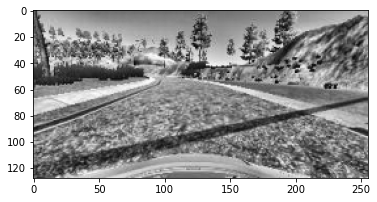

In [38]:
plt.imshow(X_train_modified[100], cmap='gray')

In [43]:
y_train[400]

-0.08140688

In [42]:
model.predict(np.expand_dims(X_train_modified[400], axis=0))

array([[-0.05449726]], dtype=float32)

In [41]:
# %run drive.py model.h5

# Fine-Tuning
Instead of re-training the network from scratch, this section can be modified to train on additional data.

In [45]:
data_dir = ['./data/trial3/', './data/trial4/', './data/trial5/']

In [46]:
df = pd.DataFrame()
for location in data_dir:
    df_ = pd.read_csv(location+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])
    # Rename data location
    df_.iloc[:,0:3] = df_.iloc[:,0:3].apply(lambda x: location + 'IMG/' + x.str.split('\\').str[-1])
    # Append to the training dataframe
    df = pd.concat([df,df_])

In [50]:
df_clean = df.copy()

In [51]:
images = []
measurements = []

df_clean['center_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x));
steering_offset = 0.02
# Left Camera Modifications
df_clean['left_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x + steering_offset));
# Right Camera Modifications
df_clean['right_cam'].apply(lambda x: images.append(mpimg.imread(x)));
df_clean['steering'].apply(lambda x: measurements.append(x - steering_offset));

X_train = np.array(images)
y_train = np.array(measurements)

In [52]:
modified_images =[]

scale_percent = 80 # percent of original size
width = int(X_train[0].shape[1] * scale_percent / 100)
height = int(X_train[0].shape[0] * scale_percent / 100)
dim = (width, height)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for image in X_train:
    normalized = image.copy()
    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])
    grayscale = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    downscaled = cv2.resize(grayscale, dim, interpolation=cv2.INTER_AREA)
    modified_images.append(downscaled)

X_train_modified = np.array(modified_images)
# Adding a dimension for Keras processing purposes
X_train_modified = np.expand_dims(X_train_modified, 3)

In [53]:
from tensorflow.keras.models import load_model
tf.keras.backend.clear_session()
model = load_model('model.h5')

log_dir = "logs\\fit\\"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [54]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_modified, y_train, epochs=30, batch_size=256, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, stopper])
model.save('model_fine_tune.h5')

Train on 36468 samples, validate on 9117 samples
Epoch 1/30
36468/36468 [==============================] - 45s 1ms/sample - loss: 0.0473 - acc: 0.1075 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 2/30
36468/36468 [==============================] - 44s 1ms/sample - loss: 0.0377 - acc: 0.1089 - val_loss: 0.0667 - val_acc: 0.0000e+00
Epoch 3/30
36468/36468 [==============================] - 44s 1ms/sample - loss: 0.0336 - acc: 0.1101 - val_loss: 0.0686 - val_acc: 0.0000e+00
Epoch 4/30
36468/36468 [==============================] - 44s 1ms/sample - loss: 0.0305 - acc: 0.1105 - val_loss: 0.0615 - val_acc: 0.0000e+00
Epoch 5/30
36468/36468 [==============================] - 44s 1ms/sample - loss: 0.0285 - acc: 0.1109 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 6/30
36468/36468 [==============================] - 43s 1ms/sample - loss: 0.0264 - acc: 0.1115 - val_loss: 0.0596 - val_acc: 0.0000e+00
Epoch 7/30
36468/36468 [==============================] - 42s 1ms/sample - loss: 0.0241 - acc